# GAN을 사용하여 MNIST 숫자 이미지 생성

In [90]:
# 패키지 임포트

import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable


import torchvision.transforms as transforms
from torchvision.utils import save_image
from torchvision import datasets
from tqdm import tqdm

In [91]:
# 하이퍼 파라미터

num_eps=100  # 에포크
bsize=128    # 배치 사이즈
lrate=0.001 #학습률
lat_dimension=64    # latent dimension
image_sz=64 # 이미지 사이즈 64x64
chnls=1     # 이미지 차원수 1 *(MNIST는 흑백 이미지)
logging_intv=200    # 몇번의 배치 수 마다 성능 출력할지
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [92]:
class GANGenerator(nn.Module):
    """
        Generator의 동작 방식
        input : (B , latene_D) - 노이즈
        output : (B , 64 , 64 , 1)
    """
    def __init__(self):
        super(GANGenerator, self).__init__()
        self.inp_sz = image_sz // 4 # 이미지 크기의 4를 나누는 이유? - 2번의 Upsampling(2배씩 커짐)
        self.lin = nn.Linear(lat_dimension, 128 * self.inp_sz ** 2) # 64차원의 노이즈를 (128 , 16 , 16) 으로 Linear Layer 통과
        self.bn1 = nn.BatchNorm2d(128)  # 배치정규화 특징 / 모든 채널 , 1개의 샘플
        self.up1 = nn.Upsample(scale_factor=2)  # 2배 키움 / 방식 : nearest , bilinear , bicubic 과 같은 방법이 있음(2장 PIL.resize에도 모두 존재하는 방법론) / default : nearest
        self.cn1 = nn.Conv2d(128, 128, 3, stride=1, padding=1)  # 3x3필터 , stride=1 이므로 양쪽에 패딩1개씩 해주면 사이즈 동일 / 의미 : 128개의 채널을 128개로 펼치고(이전 채널 모두 관여) 주변 픽셀을 보겠다.
        self.bn2 = nn.BatchNorm2d(128, 0.8) # 입실론 0.8 default 1e-05
        self.rl1 = nn.LeakyReLU(0.2, inplace=True)
        self.up2 = nn.Upsample(scale_factor=2)
        self.cn2 = nn.Conv2d(128, 64, 3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64, 0.8)
        self.rl2 = nn.LeakyReLU(0.2, inplace=True)
        self.cn3 = nn.Conv2d(64, chnls, 3, stride=1, padding=1)
        self.act = nn.Tanh()    # 출력값이 -1 ~ +1
        # nn.sequential로 안묶은 이유 => 디버깅이 쉽다!

    def forward(self, x):
        x = self.lin(x) # (B , 64) -> (B , 128*16*16)
        x = x.view(x.shape[0], 128, self.inp_sz, self.inp_sz)   
        x = self.bn1(x) 
        x = self.up1(x) # (B , 128 , 16 , 16) -> (B , 128 , 32 , 32)
        x = self.cn1(x)
        x = self.bn2(x)
        x = self.rl1(x)
        x = self.up2(x) # (B , 128 , 32 , 32) -> (B , 128 , 64 , 64)
        x = self.cn2(x) # (B , 128 , 64 , 64) -> (B , 64 , 64 , 64)
        x = self.bn3(x)
        x = self.rl2(x)
        x = self.cn3(x) # (B , 64 , 64 , 64) -> (B , 3 , 64 , 64)
        out = self.act(x)
        return out

In [93]:
class GANDiscriminator(nn.Module):
    def __init__(self):
        super(GANDiscriminator, self).__init__()

        def disc_module(ip_chnls, op_chnls, bnorm=True):    # CNN + Activation F + Dropout + BatchNorm
            mod = [nn.Conv2d(ip_chnls, op_chnls, 3, 2, 1),  # in_c , out_c , kernerl_size , stride , padding
                   nn.LeakyReLU(0.2, inplace=True), 
                   nn.Dropout2d(0.25)]
            if bnorm:
                mod += [nn.BatchNorm2d(op_chnls, 0.8)]
            return mod

        self.disc_model = nn.Sequential(
            *disc_module(chnls, 16, bnorm=False),   # (B , 3 , 64 , 64) ->(B , 16 , 32 , 32)
            *disc_module(16, 32),                   # (B , 16 , 32 , 32) ->(B , 32 , 16 , 16)
            *disc_module(32, 64),                   # (B , 32 , 16 , 16) ->(B , 64 , 8 , 8)
            *disc_module(64, 128),                  # (B , 64 , 8 , 8) ->(B , 128 , 4 , 4)
        )

        # width and height of the down-sized image
        ds_size = image_sz // 2 ** 4                # FC-layer 에 들어갈 Feature크기 4
        self.adverse_lyr = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())    # 시그모이드로 T or F 판별

    def forward(self, x):
        x = self.disc_model(x)      # 합성곱층
        x = x.view(x.shape[0], -1)
        out = self.adverse_lyr(x)   # 분류층
        return out  #(B,1)

In [94]:
# instantiate the discriminator and generator models
gen = GANGenerator().to(device)
disc = GANDiscriminator().to(device)

# define the loss metric
adv_loss_func = torch.nn.BCELoss()

In [95]:
# define the dataset and corresponding dataloader
dloader = torch.utils.data.DataLoader(
    datasets.MNIST(
        "./data/mnist/",
        download=True,
        transform=transforms.Compose(
            [transforms.Resize((image_sz, image_sz)), 
             transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
        ),
    ),
    batch_size=bsize,
    shuffle=True,
    pin_memory=True
)

# define the optimization schedule for both G and D
opt_gen = torch.optim.Adam(gen.parameters(), lr=lrate)
opt_disc = torch.optim.Adam(disc.parameters(), lr=lrate)

In [96]:
os.makedirs("./images_mnist", exist_ok=True)

G_L = []
D_L = []


for ep in tqdm(range(num_eps)):
    for idx, (images, _) in enumerate(dloader):
        # generate grounnd truths for real and fake images
        good_img = Variable(torch.FloatTensor(images.shape[0], 1).fill_(1.0), requires_grad=False).to(device)   # 진짜 이미지 label 생성
        bad_img = Variable(torch.FloatTensor(images.shape[0], 1).fill_(0.0), requires_grad=False).to(device)    # 가짜 이미지 label 생성

        # get a real image
        actual_images = Variable(images.type(torch.FloatTensor)).to(device)                                     # 진짜 이미지

        # train the generator model
        opt_gen.zero_grad()

        # generate a batch of images based on random noise as input
        noise = Variable(torch.FloatTensor(np.random.normal(0, 1, (images.shape[0], lat_dimension)))).to(device)    # 생성기에 들어갈 노이즈 생성
        gen_images = gen(noise)                                                                                     # 가짜 이미지 생성 (생성기)

        # generator model optimization - how well can it fool the discriminator
        generator_loss = adv_loss_func(disc(gen_images), good_img)                  # 생성기가 만든 이미지를 판별기가 판별 , 진짜이미지 의 손실값 계산
        generator_loss.backward()                                                   # 생성기와 판별기 그레디언트 계산
        opt_gen.step()   

        G_L.append(generator_loss.item())
    
    for idx, (images, _) in enumerate(dloader):
        # train the discriminator model
        opt_disc.zero_grad()

        # calculate discriminator loss as average of mistakes(losses) in confusing real images as fake and vice versa
        actual_image_loss = adv_loss_func(disc(actual_images), good_img)            # 실제 이미지를 판별기가 판별 , 진짜 이미지의 손실값 계산
        fake_image_loss = adv_loss_func(disc(gen_images.detach()), bad_img)         # 가짜 이미지를 판별기가 판별 , 가짜 이미지의 손실값 계산
        discriminator_loss = (actual_image_loss + fake_image_loss) / 2              # 판별기 손실값

        # discriminator model optimization
        discriminator_loss.backward()                                               # 판별기 그레디언트 계산
        opt_disc.step()                                                             # 판별기 파라미터 업데이트
        
        D_L.append(discriminator_loss.item())                                             

100%|██████████| 100/100 [1:44:48<00:00, 62.89s/it]


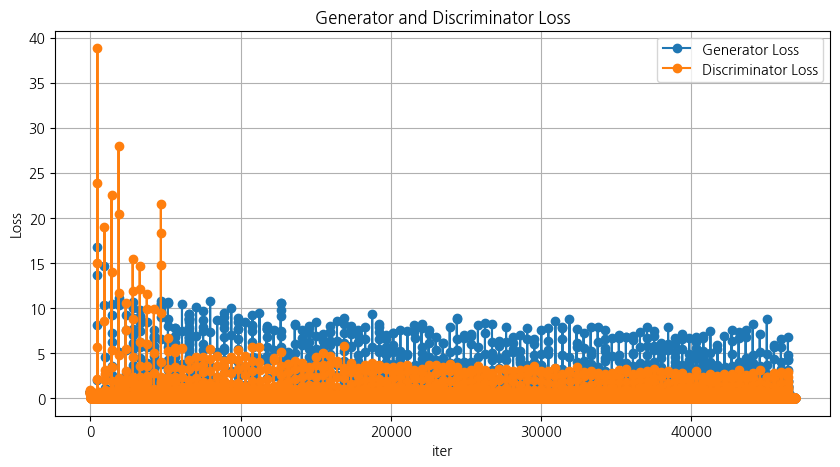

In [97]:
# 시각화

import matplotlib.pyplot as plt

# 손실 값 시각화
plt.figure(figsize=(10, 5))
x_ticks = [i * 1  for i in range(1, len(G_L) + 1)]
plt.plot(x_ticks, G_L, label='Generator Loss', marker='o')
plt.plot(x_ticks, D_L, label='Discriminator Loss', marker='o')

plt.xlabel('iter')
plt.ylabel('Loss')
plt.title('Generator and Discriminator Loss')
plt.legend()
plt.grid(True)
plt.show()

# 결과물

![DCGAN_image](https://github.com/wikibook/mpytc/assets/91838563/5287a839-6c96-427f-9c69-12a6b60c6a55)